In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#check version
print("OpenCv version: {}", cv2.__version__)

OpenCv version: {} 4.5.3


In [2]:
# Parameters for binarize threshold and Canny Line detection
bi_thd = 20
bi_max = 255

nor_color = (0, 255, 255)
warn_color = (0,0,255)
font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 255, 255)

In [3]:
def displayResizedImg(name, img, factor):
    imgDis = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_AREA)
    cv2.imshow(name, imgDis)
    return imgDis

In [4]:
#read from file
img = cv2.imread("D:/Research/opencv/image/slant_edge.png")
#img = cv2.imread("D:/Research/opencv/image/wallpaper.png")
#img = cv2.imread("D:/Research/opencv/image/ISO12233.jpg")
#Convert image to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
#Select and Crop image
showCrosshair = False
fromCenter = False
# Select ROI
#x,y,w,h = (343,226,75,75)
rect = cv2.selectROI("select roi", gray, showCrosshair, fromCenter)
x, y, w, h = rect
#print(x,y,w,h)

# Crop image
imgGrayCrop = gray[y : y+h, x:x+w]
imCrop = img[y : y+h, x:x+w]

In [6]:
# Edge detection
#find gradient
imgGrayCrop = cv2.blur(imgGrayCrop, (3,3))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
gradient = cv2.morphologyEx(imgGrayCrop, cv2.MORPH_GRADIENT, kernel, iterations=3)

# to get better lines
#gradient = cv2.morphologyEx(gradient, cv2.MORPH_OPEN, kernel, iterations=3)
gradient = cv2.erode(gradient, kernel, iterations = 2)
ret, gradient = cv2.threshold(gradient, bi_thd, bi_max, cv2.THRESH_BINARY)
#gradient = cv2.erode(gradient, kernel, iterations = 1)

#mask = np.zeros(gradient.shape, dtype="uint8")
contours, hierarchy = cv2.findContours(gradient,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
(x, y, w, h) = cv2.boundingRect(contours[0])
#cv2.rectangle(mask, (x, y), (x + w, y + h), (255), cv2.FILLED)
#masked = cv2.bitwise_and(imgGrayCrop, imgGrayCrop, mask=mask)
roi = imgGrayCrop[y:y+h, x-10:x+w+10]


In [7]:
#ESF
num_rows, num_cols = roi.shape
#print(num_rows, num_cols)

#Centroid edge profile
cep_h = np.zeros(num_cols, dtype="uint8")
temp = 0
for col in range(0, num_cols):
    for row in range(0,num_rows):
        temp += roi[row,col]
    cep_h[col] = temp/num_rows
    temp = 0
    
cep_v = np.zeros(num_rows, dtype="uint8")
for row in range(0,num_rows):
    for col in range(0, num_cols):
        temp += roi[row,col]
    cep_v[row] = temp/num_cols
    temp = 0


In [8]:
#LSF (1st derivative of ESF) Same as a convolutin with a [1,0,-1] matrix
lsf_h = np.gradient(cep_h,1)
lsf_v = np.gradient(cep_v,1)


MTF [ 0 ]:      57.77 ,     85.91
MTF [ 1 ]:      48.51 ,      4.27
MTF [ 2 ]:      28.66 ,      8.63
MTF [ 3 ]:      10.73 ,      7.97
MTF [ 4 ]:       0.96 ,      2.93


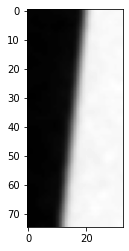

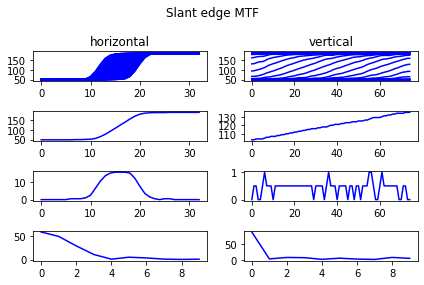

In [9]:
#SFR (Absolute value of Fourier transform of the LSF)
sfr_h = np.absolute(np.fft.fft(lsf_h))
sfr_v = np.absolute(np.fft.fft(lsf_v))

#Data normalization
sfr_h = sfr_h/np.linalg.norm(sfr_h)*100
sfr_v = sfr_v/np.linalg.norm(sfr_v)*100

for i in range(0, 5):
    print("MTF [", i,"]:", "{:10.2f}".format(sfr_h[i]), ",{:10.2f}".format(sfr_v[i]))
    
    
#Data visualization
plt.imshow(roi, cmap='gray')
plt.show()

fig, ax = plt.subplots(4,2)
fig.suptitle('Slant edge MTF')
ax[0,0].set_title('horizontal')
ax[0,1].set_title('vertical')
ax[0,0].plot(np.transpose(roi), '-', color='blue');
ax[0,1].plot(roi, '-', color='blue');
ax[1,0].plot(cep_h, '-', color='blue');
ax[1,1].plot(cep_v, '-', color='blue');
ax[2,0].plot(lsf_h, '-', color='blue');
ax[2,1].plot(lsf_v, '-', color='blue');
ax[3,0].plot(sfr_h[:10], '-', color='blue');
ax[3,1].plot(sfr_v[:10], '-', color='blue');
fig.tight_layout()

In [10]:
## displayResizedImg('gray', gray, 0.8)
#displayResizedImg('ori', imCrop, 4)
##displayResizedImg('edge', edges, 2)
#displayResizedImg('gradient', gradient, 2)
#displayResizedImg('mask', mask, 4)
#displayResizedImg('masked', masked, 4)
#displayResizedImg('roi', roi, 4)
cv2.waitKey()
cv2.destroyAllWindows()